In [21]:
!pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.9 MB/s eta 0:00:00


In [22]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [23]:
from tensorflow.keras.layers import Rescaling

In [24]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2025-04-14 08:58:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-04-14 08:58:35 (13.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [25]:
BATCH_SIZE = 32
IMAGE_SIZE = (320, 320)

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# Define root_dir with the correct path to your dataset
dataset = '/content/drive/MyDrive/fire/fire_dataset'

In [28]:
walk_through_dir(dataset)

There are 2 directories and 0 images in '/content/drive/MyDrive/fire/fire_dataset'.
There are 0 directories and 246 images in '/content/drive/MyDrive/fire/fire_dataset/non_fire_images'.
There are 0 directories and 755 images in '/content/drive/MyDrive/fire/fire_dataset/fire_images'.


In [29]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [30]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [31]:
len(list(image_dir.glob(r'**/*.png')))

1001

In [32]:
image_df

,Filepath,Label
0,/content/drive/MyDrive/fire/fire_dataset/non_f...,non_fire_images
1,/content/drive/MyDrive/fire/fire_dataset/non_f...,non_fire_images
2,/content/drive/MyDrive/fire/fire_dataset/non_f...,non_fire_images
3,/content/drive/MyDrive/fire/fire_dataset/non_f...,non_fire_images
4,/content/drive/MyDrive/fire/fire_dataset/non_f...,non_fire_images
...,...,...
996,/content/drive/MyDrive/fire/fire_dataset/fire_...,fire_images
997,/content/drive/MyDrive/fire/fire_dataset/fire_...,fire_images
998,/content/drive/MyDrive/fire/fire_dataset/fire_...,fire_images
999,/content/drive/MyDrive/fire/fire_dataset/fire_...,fire_images


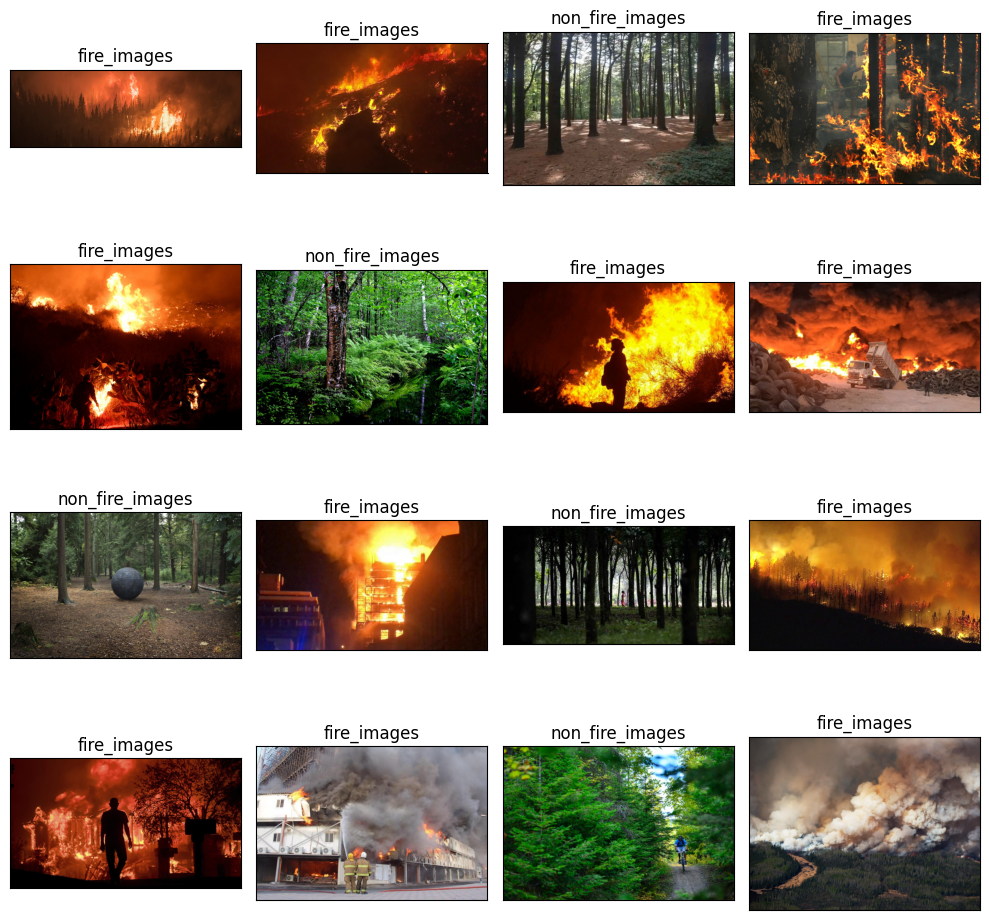

In [33]:
import matplotlib.image as mpimg
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(image_df.Filepath[random_index[i]])
    ax.imshow(image)
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [36]:
# Separate in train and test data and validation
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 640 validated image filenames belonging to 2 classes.
Found 160 validated image filenames belonging to 2 classes.
Found 201 validated image filenames belonging to 2 classes.


In [38]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(224, 224),
  layers.Rescaling(1./255),
])

In [39]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [41]:
# Create checkpoint callback
checkpoint_path = "fires_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [42]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [43]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "fire_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/fire_classification/20250414-090349


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 268s 13s/step - accuracy: 0.7771 - loss: 0.4678 - val_accuracy: 0.9250 - val_loss: 0.2051
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9520 - loss: 0.1578 - val_accuracy: 0.9375 - val_loss: 0.1417
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9638 - loss: 0.1192 - val_accuracy: 0.9438 - val_loss: 0.1186
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9799 - loss: 0.0669 - val_accuracy: 0.9500 - val_loss: 0.1057
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9850 - loss: 0.0742 - val_accuracy: 0.9500 - val_loss: 0.1004
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9788 - loss: 0.0527 - val_accuracy: 0.9750 - val_loss: 0.0861
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9908 - loss: 0.0590 - val_accuracy: 0.9750 - val_loss: 0.0748
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9818 - loss: 0.0489 - val_accuracy: 0.9688 -

In [44]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.05310
Test Accuracy: 98.51%


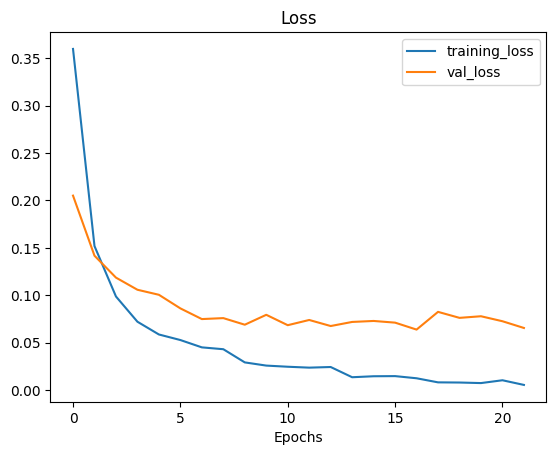

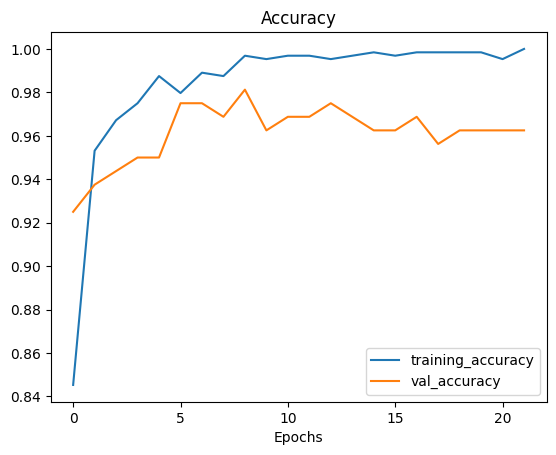

In [45]:
plot_loss_curves(history)

In [46]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
The first 5 predictions: ['fire_images', 'fire_images', 'fire_images', 'fire_images', 'fire_images']


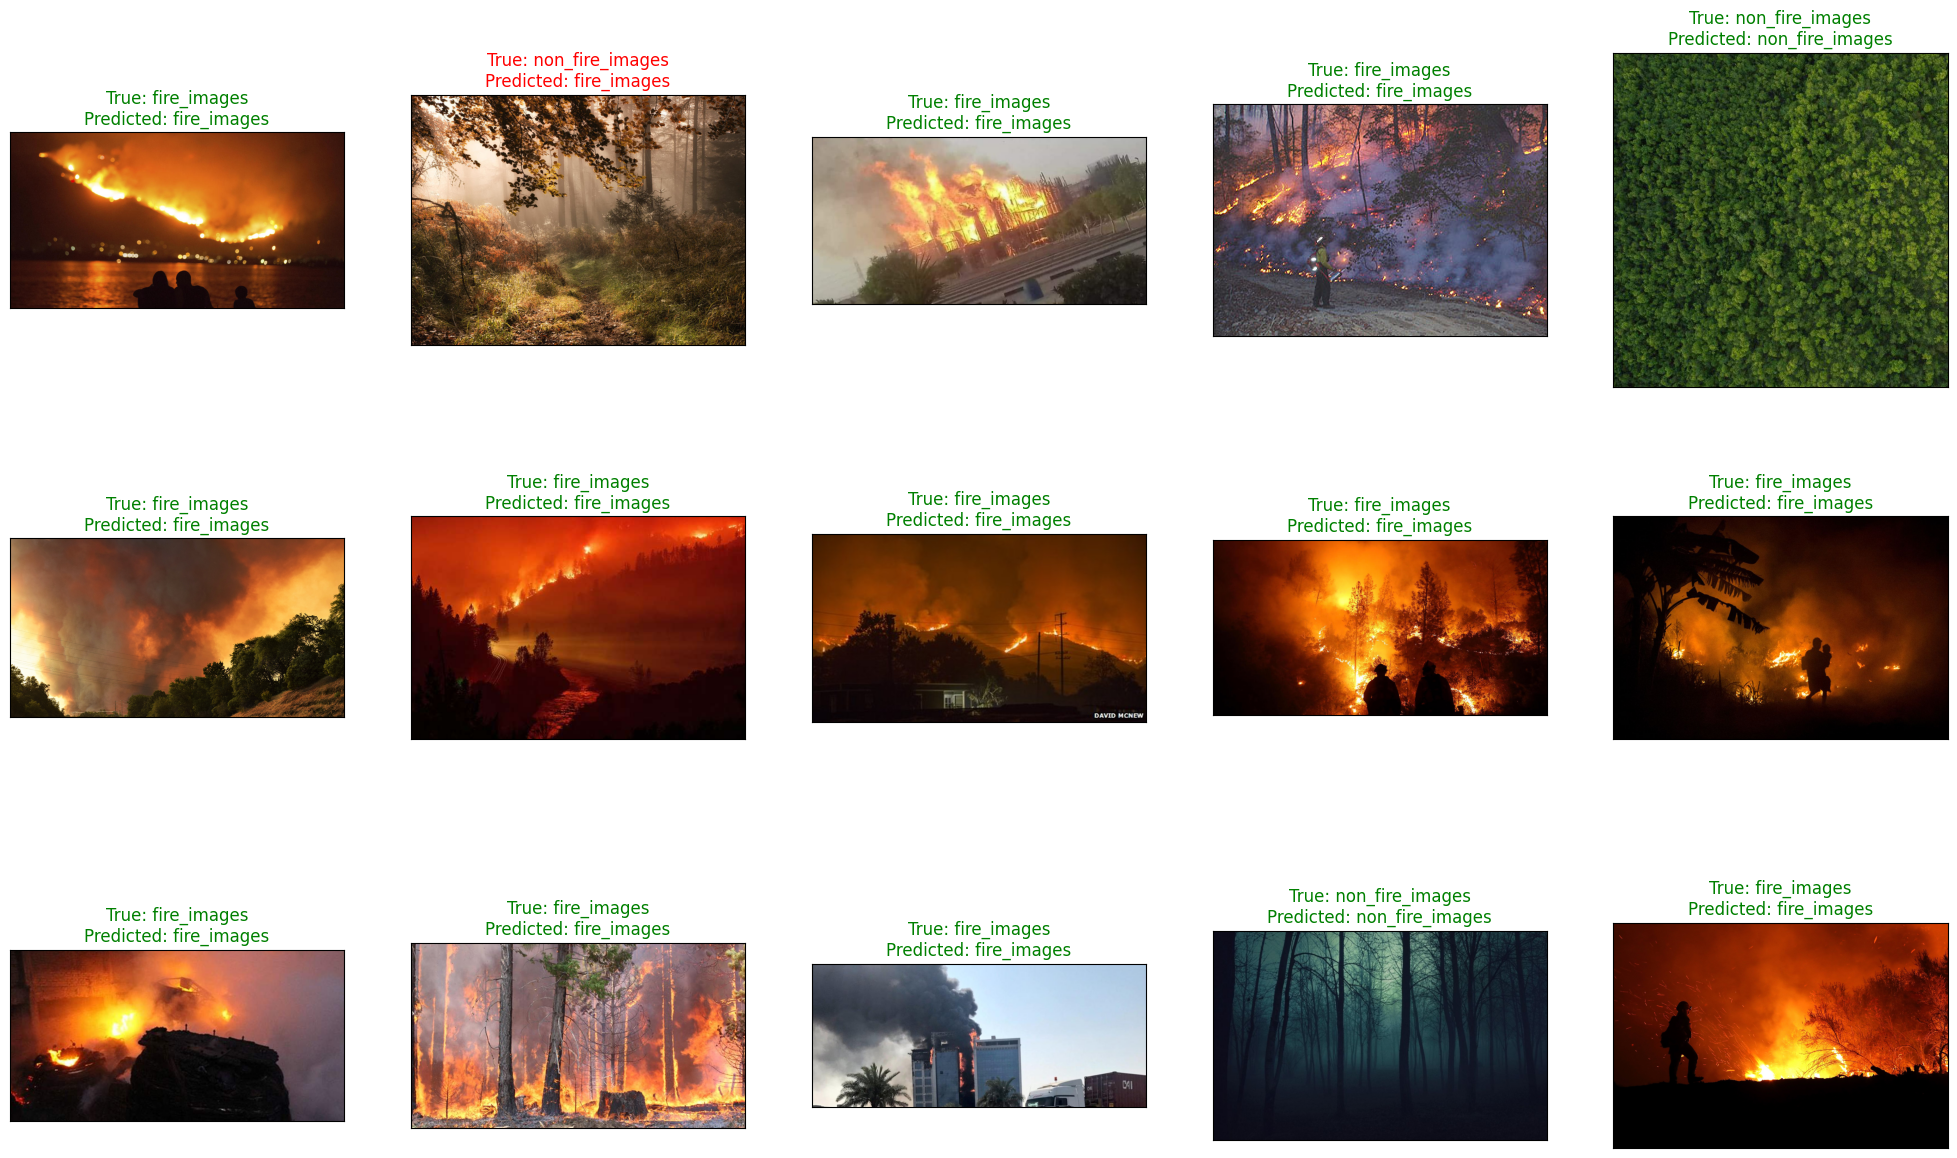

<Figure size 640x480 with 0 Axes>

In [47]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(test_df.Filepath.iloc[random_index[i]])
    ax.imshow(image)
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [48]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                 precision    recall  f1-score   support

    fire_images       0.98      1.00      0.99       157
non_fire_images       1.00      0.93      0.96        44

       accuracy                           0.99       201
      macro avg       0.99      0.97      0.98       201
   weighted avg       0.99      0.99      0.98       201



In [49]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
fire_images,0.981250,1.000000,0.990536,157.000000
non_fire_images,1.000000,0.931818,0.964706,44.000000
accuracy,0.985075,0.985075,0.985075,0.985075
macro avg,0.990625,0.965909,0.977621,201.000000
weighted avg,0.985354,0.985075,0.984882,201.000000


In [52]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False):

  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

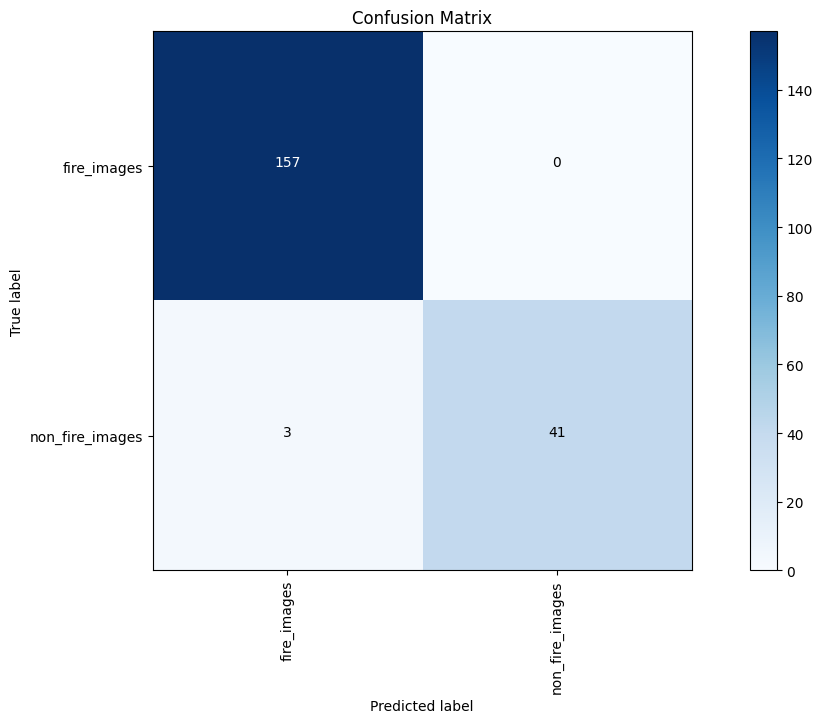

In [53]:
make_confusion_matrix(y_test, pred, list(labels.values()))

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from pathlib import Path
import os.path
import pandas as pd

In [16]:
# Define paths and parameters
dataset_path = '/content/drive/MyDrive/fire/fire_dataset'  # Update with your dataset path
image_size = (256, 256)
batch_size = 32

# Create image dataframe
image_dir = Path(dataset_path)
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
image_df = pd.concat([filepaths, labels], axis=1)

In [17]:
# Split data into train and test sets
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

# Create data generators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 640 validated image filenames belonging to 2 classes.
Found 160 validated image filenames belonging to 2 classes.
Found 201 validated image filenames belonging to 2 classes.


In [19]:
# Define the CNN model
model = Sequential([
    Input(shape=(256, 256, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Flatten(),
    Dense(2, activation='softmax')  # 2 classes (fire/non-fire)
])


In [20]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,  # Adjust as needed
    validation_data=validation_generator
)

# Evaluate the model
_, accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {accuracy:.2f}") # This line was causing the error

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.7294 - loss: 0.4870 - val_accuracy: 0.9062 - val_loss: 0.3322
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.9409 - loss: 0.1638 - val_accuracy: 0.9500 - val_loss: 0.1307
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.9640 - loss: 0.1052 - val_accuracy: 0.9625 - val_loss: 0.1406
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.9831 - loss: 0.0497 - val_accuracy: 0.9312 - val_loss: 0.3395
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.9137 - loss: 0.1910 - val_accuracy: 0.9000 - val_loss: 0.1840
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.9634 - loss: 0.1029 - val_accuracy: 0.9438 - val_loss: 0.1842
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.9720 - loss: 0.0695 - val_accuracy: 0.9563 - val_loss: 0.1164
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.9703 - loss: 0.0727 - val_accuracy: 0.9500 - val_loss:

In [22]:
model.export('/content/drive/MyDrive/fire/saved_model')

Saved artifact at '/content/drive/MyDrive/fire/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_11')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  139618367952784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139618367954512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139618367953936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139618367955280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139618367954704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139618367956048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139618367955472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139618367956816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139618367956240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139618367957584: TensorSpec(shape=(), dtype=tf.resource, n

In [89]:
# Konversi model ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite
with open('/content/drive/MyDrive/fire/model.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpzfrom9ot'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_219')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  133187367314896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133187367317008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133187367316432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133187367317776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133187367317200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133187367318544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133187367317968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133187367319312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133187367318736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133187367320080: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [23]:
!pip install tensorflowjs

In [24]:
# ... (your previous code for defining, compiling, and training the model) ...

# Save the model in TFJS format
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, '/content/drive/MyDrive/fire/tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file
